In [22]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb
import glob
import os

from tensorboard.backend.event_processing import event_accumulator


In [81]:
def get_seeds_df(reward, algo, num_sprites, random_init_places=True):
    dirs = "./logs/{}/{}/{}sprites/{}_{}_seed{}".format(reward,algo,str(num_sprites), "all_sprite_mover", "random_init" if random_init_places else "fixed_init", "*")
    events_dirs = glob.glob(dirs)
    events_dirs = filter(os.path.isdir, events_dirs)
    events_df = []
    for event_dir in events_dirs:
        ea = event_accumulator.EventAccumulator(event_dir, size_guidance={event_accumulator.SCALARS: 0})
        ea.Reload()
        dframes = {}
        mnames = ea.Tags()['scalars']
        
        for n in mnames:
            if "train" in n :
                continue
            dframes[n] = pd.DataFrame(ea.Scalars(n), columns=["wall_time", "epoch", n.replace('val/', '')])
            dframes[n].drop("wall_time", axis=1, inplace=True)
            dframes[n] = dframes[n].set_index("epoch")
            df =  pd.concat([v for k,v in dframes.items()], axis=1)
        #df = df.sort_values(by=['epoch'])
        events_df.append(df)
        
    return events_df


In [82]:
a = get_seeds_df("l2_reward","TD3",2,True)

In [101]:



def aggregate_events(reward, algo, num_sprites, random_init_places=True):
    seeds_df = get_seeds_df(reward, algo, num_sprites, random_init_places)
    
    mean_rewards = []
    
    for df_idx, df in enumerate(seeds_df):
        mean_rewards.append(df["emean_reward"].values)
    
    max_len = max([r.shape[0] for r in mean_rewards])
    mean_rewards_full = np.zeros((len(seeds_df),max_len))
    
    for i in range(len(seeds_df)):
        mean_rewards_full[i] = np.full((max_len,), mean_rewards[i][-1])
        mean_rewards_full[i,:mean_rewards[i].shape[0]] = mean_rewards[i]
        plt.plot(mean_rewards_full[i],alpha=0.3)
    
    average_reward = np.mean(mean_rewards_full,axis=0)
    plt.plot(average_reward)
    
    plt.show()
        

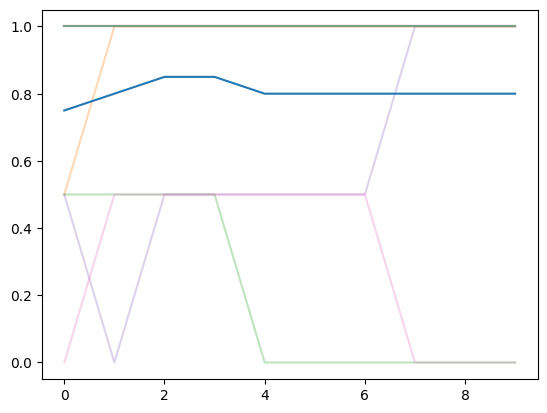

In [125]:
aggregate_events("contact_reward","TD3",2,False)